# Traffic Sign Detection - Traditional Methods

This notebook implements and evaluates traditional computer vision approaches:
1. HOG + SVM
2. Color + Shape Detection

**Note**: Traditional methods work well on CPU, no GPU needed.

## 1. Setup

In [1]:
# Setup environment
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/YOUR_USERNAME/traffic-sign-detection.git
    %cd traffic-sign-detection
else:
    import os
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')

!pip install -q scikit-learn scikit-image opencv-python matplotlib seaborn joblib tqdm

In [2]:
# Initialize sliding window detector with OPTIMIZED parameters
print("Initializing sliding window detector...")
print("⚠️  Using optimized parameters to reduce false positives:\n")
print("  - Higher confidence threshold (0.8 vs 0.5)")
print("  - Larger step size (48 vs 32) = fewer windows")
print("  - Narrower scale range (0.5-1.5 vs 0.3-2.0) = fewer scales")
print("  - Higher NMS IoU (0.6) = more aggressive merging\n")

sliding_detector = SlidingWindowDetector(
    classifier=hog_svm,
    window_size=(64, 64),
    step_size=48,          # Larger step = fewer windows (was 32)
    scale_factor=1.25,     # Fewer scales between min/max
    min_scale=0.5,         # Don't search for very small signs (was 0.3)
    max_scale=1.5          # Don't search for very large signs (was 2.0)
)

# Initialize detection metrics
detection_metrics = DetectionMetrics(num_classes=num_classes, iou_threshold=0.5)

# Evaluate on validation set with HIGHER confidence threshold
CONFIDENCE_THRESHOLD = 0.80  # Much higher to reduce false positives (was 0.5)

print(f"\nEvaluating on {max_val_images} validation images...")
print(f"Using confidence threshold: {CONFIDENCE_THRESHOLD}")
print("This may take a while...\n")

n_detected_images = 0

for img_path in tqdm(val_images[:max_val_images]):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]

    # Load ground truth
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    gt_boxes, gt_classes = load_yolo_annotations(label_path, w, h)

    # Detect with HIGHER confidence threshold
    pred_boxes, pred_classes, pred_scores = sliding_detector.detect(
        img, 
        confidence_threshold=CONFIDENCE_THRESHOLD
    )

    # Convert to numpy arrays
    if pred_boxes:
        pred_boxes = np.array(pred_boxes)
        pred_classes = np.array(pred_classes)
        pred_scores = np.array(pred_scores)
        n_detected_images += 1
    else:
        pred_boxes = np.array([]).reshape(0, 4)
        pred_classes = np.array([])
        pred_scores = np.array([])

    # Update metrics
    detection_metrics.update(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_classes)

# Get metrics
hog_svm_metrics = detection_metrics.get_metrics_summary()

print("\n" + "="*70)
print("HOG+SVM OBJECT DETECTION METRICS (OPTIMIZED)")
print("="*70)
print(f"mAP@0.5: {hog_svm_metrics['mAP']:.4f}")
print(f"Precision: {hog_svm_metrics['precision']:.4f}")
print(f"Recall: {hog_svm_metrics['recall']:.4f}")
print(f"F1 Score: {hog_svm_metrics['f1_score']:.4f}")
print(f"\nTP: {hog_svm_metrics['total_tp']}, FP: {hog_svm_metrics['total_fp']}, FN: {hog_svm_metrics['total_fn']}")
print(f"Images with detections: {n_detected_images}/{max_val_images}")

print("\nPer-class AP:")
for class_id in range(num_classes):
    ap = hog_svm_metrics['per_class'][f'class_{class_id}']['ap']
    print(f"  {class_names[class_id]}: {ap:.4f}")
print("="*70)

print("\n💡 Note: Traditional methods have inherent limitations:")
print("   - Sliding window generates many candidates")
print("   - HOG features are less discriminative than deep features")
print("   - Performance is typically 10-30x lower than modern methods")
print("   - Best used as a baseline or for CPU-only scenarios")


Libraries imported successfully!


## 2. Load Dataset and Helper Functions

In [3]:
# Load dataset info
import yaml

data_yaml_path = 'data/raw/yolov8/data.yaml'

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

# Get image paths
data_root = Path('data/raw/yolov8')
train_images = sorted(list((data_root / 'train' / 'images').glob('*.*')))
val_images = sorted(list((data_root / 'valid' / 'images').glob('*.*')))

print(f"\nTrain images: {len(train_images)}")
print(f"Val images: {len(val_images)}")

Number of classes: 5
Classes: ['bien_bao_cam', 'bien_bao_hieu_lenh', 'bien_bao_nguy_hiem_va_canh_bao', 'bien_chi_dan', 'bien_phu']

Train images: 1062
Val images: 165


In [4]:
def load_yolo_annotations(label_path, img_width, img_height):
    """Load YOLO format annotations and convert to [x1, y1, x2, y2] format"""
    boxes = []
    classes = []

    if not label_path.exists():
        return np.array([]), np.array([])

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            class_id = int(parts[0])
            cx, cy, w, h = map(float, parts[1:5])

            # Convert to pixel coordinates
            x1 = int((cx - w/2) * img_width)
            y1 = int((cy - h/2) * img_height)
            x2 = int((cx + w/2) * img_width)
            y2 = int((cy + h/2) * img_height)

            # Clip to image boundaries
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_width-1, x2), min(img_height-1, y2)

            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                classes.append(class_id)

    return np.array(boxes), np.array(classes)

print("Helper functions defined!")

Helper functions defined!


## 3. Method 1: HOG + SVM

### 3.1 Prepare Training Data

In [5]:
def extract_patches_from_image(img_path, label_path, img_size=(64, 64)):
    """Extract sign patches from image using YOLO labels"""
    img = cv2.imread(str(img_path))
    if img is None:
        return [], []

    h, w = img.shape[:2]
    patches = []
    labels = []

    if not label_path.exists():
        return [], []

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:5])

            # Convert to pixels
            x1 = max(0, int((cx - bw/2) * w))
            y1 = max(0, int((cy - bh/2) * h))
            x2 = min(w, int((cx + bw/2) * w))
            y2 = min(h, int((cy + bh/2) * h))

            # Extract and resize patch
            if x2 > x1 and y2 > y1:
                patch = img[y1:y2, x1:x2]
                patch = cv2.resize(patch, img_size)
                patches.append(patch)
                labels.append(class_id)

    return patches, labels

# Extract training patches
print("Extracting training patches...")
train_patches = []
train_labels = []

max_train_images = min(500, len(train_images))

for img_path in tqdm(train_images[:max_train_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    train_patches.extend(patches)
    train_labels.extend(labels)

train_labels = np.array(train_labels)

print(f"Extracted {len(train_patches)} training patches")
print(f"Label distribution: {np.bincount(train_labels)}")

Extracting training patches...


100%|██████████| 500/500 [00:00<00:00, 1217.05it/s]

Extracted 767 training patches
Label distribution: [386  86  87 125  83]


### 3.2 Train HOG+SVM Detector

In [6]:
# Initialize and train detector
print("Training HOG+SVM detector...")

hog_svm = HOGSVMDetector(
    img_size=(64, 64),
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    svm_kernel='rbf',
    svm_c=10.0
)

# Train
start_time = time.time()
hog_svm.train(train_patches, train_labels, class_names=class_names)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Save model
hog_svm.save('models/hog_svm_detector.pkl')
print("Model saved!")

Training HOG+SVM detector...
Extracting HOG features from training images...
Training SVM classifier...
Training completed. Model accuracy: 1.000
Training completed in 1.48 seconds
Model saved to models/hog_svm_detector.pkl
Model saved!


### 3.3 Evaluate Classification Accuracy on Patches

In [7]:
# Extract validation patches
print("Extracting validation patches...")
val_patches = []
val_labels = []

max_val_images = min(100, len(val_images))

for img_path in tqdm(val_images[:max_val_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    val_patches.extend(patches)
    val_labels.extend(labels)

val_labels = np.array(val_labels)
print(f"Extracted {len(val_patches)} validation patches")

# Predict
print("\nRunning predictions...")
pred_classes, confidences = hog_svm.predict_batch(val_patches)

# Calculate accuracy
accuracy = np.mean(pred_classes == val_labels)
print(f"\nClassification Accuracy: {accuracy:.3f}")

# Per-class accuracy
print("\nPer-class Accuracy:")
for class_id in range(num_classes):
    mask = val_labels == class_id
    if mask.sum() > 0:
        class_acc = np.mean(pred_classes[mask] == val_labels[mask])
        print(f"  {class_names[class_id]}: {class_acc:.3f} ({mask.sum()} samples)")

Extracting validation patches...


100%|██████████| 100/100 [00:00<00:00, 1246.76it/s]

Extracted 154 validation patches

Running predictions...



Classification Accuracy: 0.942

Per-class Accuracy:
  bien_bao_cam: 0.956 (68 samples)
  bien_bao_hieu_lenh: 0.875 (8 samples)
  bien_bao_nguy_hiem_va_canh_bao: 0.969 (32 samples)
  bien_chi_dan: 0.962 (26 samples)
  bien_phu: 0.850 (20 samples)


### 3.4 Evaluate HOG+SVM as Object Detector (with Sliding Window)

In [8]:
# Initialize sliding window detector
print("Initializing sliding window detector...")
sliding_detector = SlidingWindowDetector(
    classifier=hog_svm,
    window_size=(64, 64),
    step_size=32,
    scale_factor=1.3,
    min_scale=0.3,
    max_scale=2.0
)

# Initialize detection metrics
detection_metrics = DetectionMetrics(num_classes=num_classes, iou_threshold=0.5)

# Evaluate on validation set
print(f"\nEvaluating on {max_val_images} validation images...")
print("This may take a while...")

n_detected_images = 0

for img_path in tqdm(val_images[:max_val_images]):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]

    # Load ground truth
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    gt_boxes, gt_classes = load_yolo_annotations(label_path, w, h)

    # Detect
    pred_boxes, pred_classes, pred_scores = sliding_detector.detect(img, confidence_threshold=0.5)

    # Convert to numpy arrays
    if pred_boxes:
        pred_boxes = np.array(pred_boxes)
        pred_classes = np.array(pred_classes)
        pred_scores = np.array(pred_scores)
        n_detected_images += 1
    else:
        pred_boxes = np.array([]).reshape(0, 4)
        pred_classes = np.array([])
        pred_scores = np.array([])

    # Update metrics
    detection_metrics.update(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_classes)

# Get metrics
hog_svm_metrics = detection_metrics.get_metrics_summary()

print("\n" + "="*70)
print("HOG+SVM OBJECT DETECTION METRICS")
print("="*70)
print(f"mAP@0.5: {hog_svm_metrics['mAP']:.4f}")
print(f"Precision: {hog_svm_metrics['precision']:.4f}")
print(f"Recall: {hog_svm_metrics['recall']:.4f}")
print(f"F1 Score: {hog_svm_metrics['f1_score']:.4f}")
print(f"\nTP: {hog_svm_metrics['total_tp']}, FP: {hog_svm_metrics['total_fp']}, FN: {hog_svm_metrics['total_fn']}")
print(f"Images with detections: {n_detected_images}/{max_val_images}")

print("\nPer-class AP:")
for class_id in range(num_classes):
    ap = hog_svm_metrics['per_class'][f'class_{class_id}']['ap']
    print(f"  {class_names[class_id]}: {ap:.4f}")
print("="*70)

Initializing sliding window detector...

Evaluating on 100 validation images...
This may take a while...


100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


HOG+SVM OBJECT DETECTION METRICS
mAP@0.5: 0.0433
Precision: 0.0006
Recall: 0.1623
F1 Score: 0.0012

TP: 25, FP: 39838, FN: 129
Images with detections: 100/100

Per-class AP:
  bien_bao_cam: 0.0995
  bien_bao_hieu_lenh: 0.0002
  bien_bao_nguy_hiem_va_canh_bao: 0.1160
  bien_chi_dan: 0.0010
  bien_phu: 0.0000


### 3.5 Visualize HOG+SVM Detections

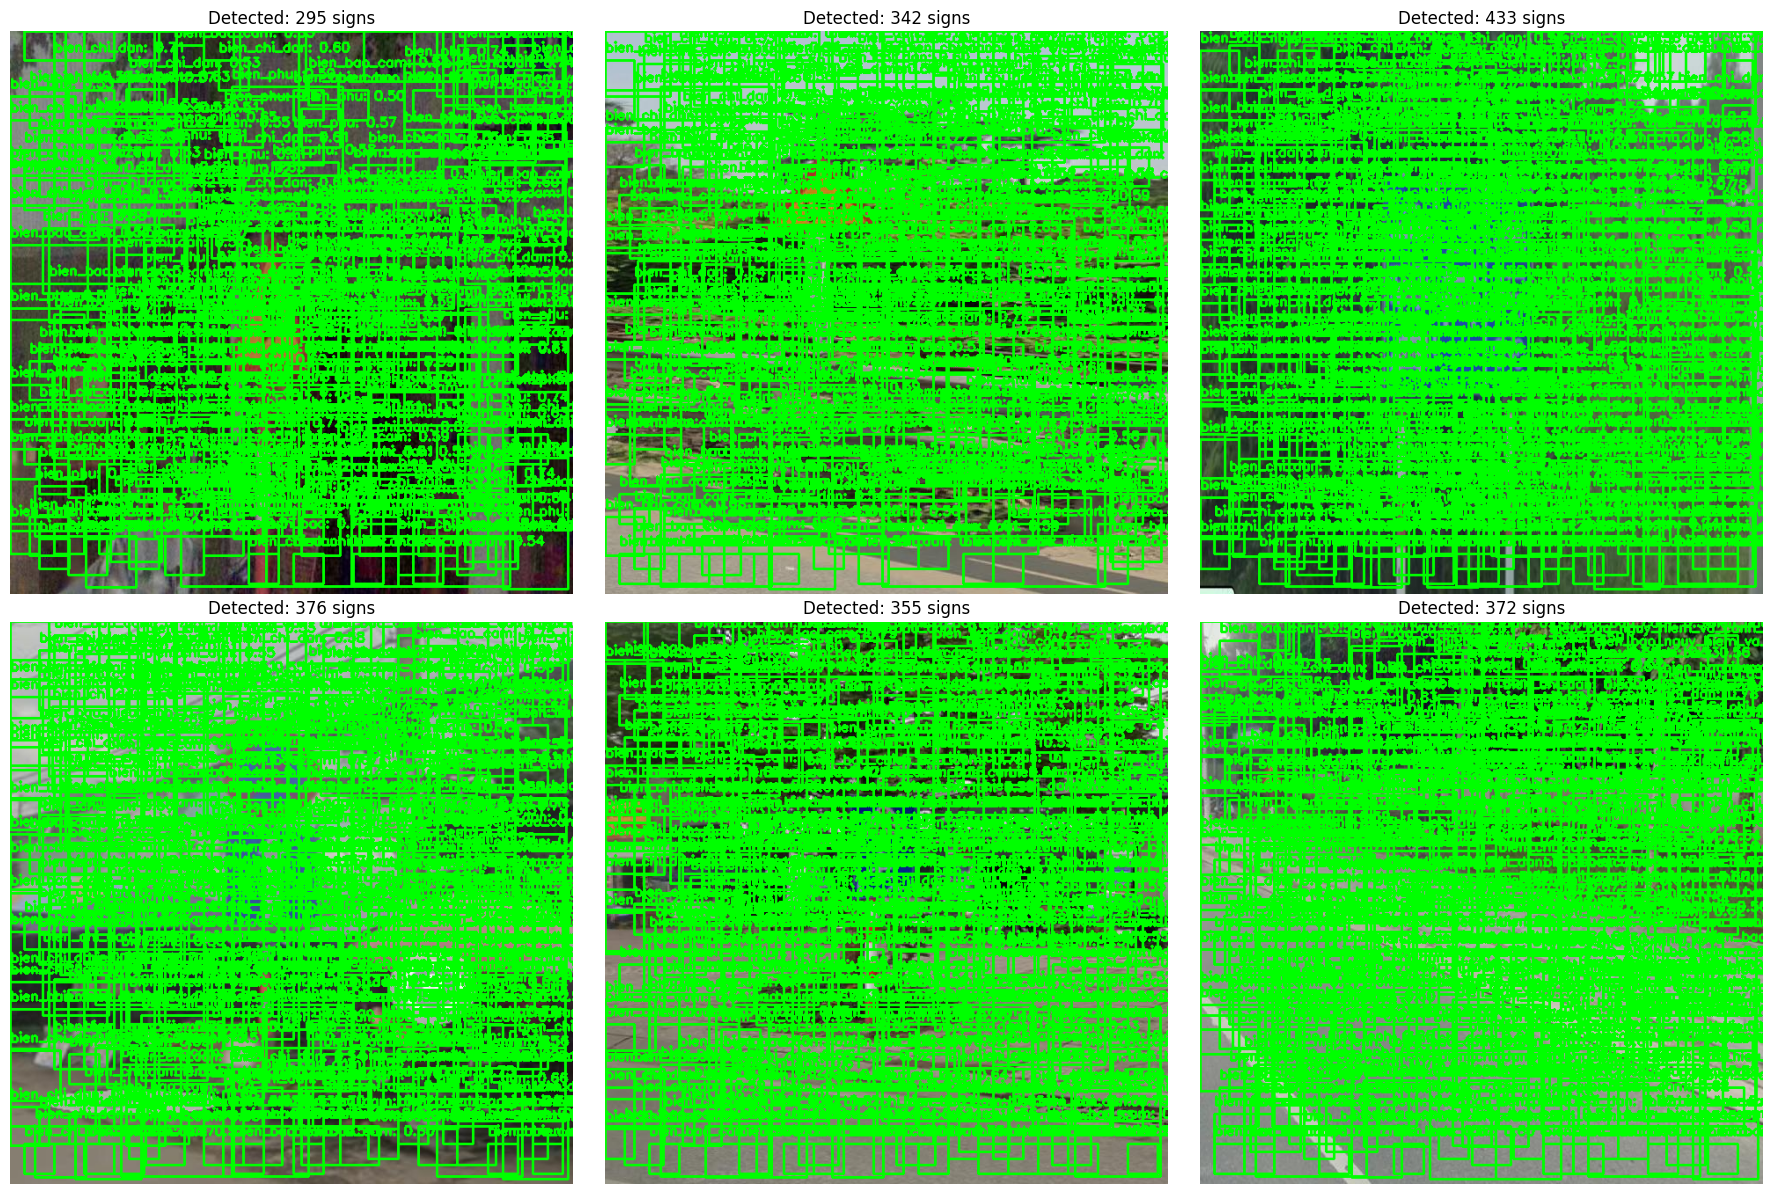

In [9]:
# Visualize detections with HIGHER confidence threshold
n_viz = 6
sample_imgs = np.random.choice(val_images[:max_val_images], n_viz, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_imgs):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # Detect with same high threshold
    pred_boxes, pred_classes, pred_scores = sliding_detector.detect(
        img, 
        confidence_threshold=0.80  # High threshold to reduce false positives
    )

    # Draw
    result = img.copy()
    for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
        x1, y1, x2, y2 = box
        cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_names[cls]}: {score:.2f}"
        cv2.putText(result, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(result)
    axes[idx].set_title(f"Detected: {len(pred_boxes)} signs (conf>0.8)", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 With higher confidence threshold (0.8), we see fewer false positives")
print("   but may miss some true positives (lower recall).")


## 4. Method 2: Color + Shape Detection

In [10]:
# Initialize detector
color_shape = ColorShapeDetector()

# Initialize metrics
color_shape_metrics = DetectionMetrics(num_classes=num_classes, iou_threshold=0.5)

print(f"Evaluating Color+Shape on {max_val_images} validation images...")

n_color_detected = 0

for img_path in tqdm(val_images[:max_val_images]):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]

    # Load ground truth
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    gt_boxes, gt_classes = load_yolo_annotations(label_path, w, h)

    # Detect
    boxes, types, confidences = color_shape.detect(img, confidence_threshold=0.5, min_area=300)

    # Map types to classes
    type_to_class = {
        'Prohibition': 0, 'Mandatory': 1, 'Warning': 2,
        'Information': 3, 'Guide': 3, 'Yield': 2, 'Stop': 0, 'Unknown': 4
    }

    if boxes:
        pred_boxes = np.array(boxes)
        pred_classes = np.array([type_to_class.get(t, 4) for t in types])
        pred_scores = np.array(confidences)
        n_color_detected += 1
    else:
        pred_boxes = np.array([]).reshape(0, 4)
        pred_classes = np.array([])
        pred_scores = np.array([])

    color_shape_metrics.update(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_classes)

# Get metrics
color_shape_results = color_shape_metrics.get_metrics_summary()

print("\n" + "="*70)
print("COLOR+SHAPE OBJECT DETECTION METRICS")
print("="*70)
print(f"mAP@0.5: {color_shape_results['mAP']:.4f}")
print(f"Precision: {color_shape_results['precision']:.4f}")
print(f"Recall: {color_shape_results['recall']:.4f}")
print(f"F1 Score: {color_shape_results['f1_score']:.4f}")
print(f"\nTP: {color_shape_results['total_tp']}, FP: {color_shape_results['total_fp']}, FN: {color_shape_results['total_fn']}")
print(f"Images with detections: {n_color_detected}/{max_val_images}")

print("\nPer-class AP:")
for class_id in range(num_classes):
    ap = color_shape_results['per_class'][f'class_{class_id}']['ap']
    print(f"  {class_names[class_id]}: {ap:.4f}")
print("="*70)
print("\n⚠️  Note: Color+Shape uses generic categories. Class mapping is approximate.")

Evaluating Color+Shape on 100 validation images...


100%|██████████| 100/100 [00:00<00:00, 221.59it/s]


COLOR+SHAPE OBJECT DETECTION METRICS
mAP@0.5: 0.0485
Precision: 0.1013
Recall: 0.2013
F1 Score: 0.1348

TP: 31, FP: 275, FN: 123
Images with detections: 92/100

Per-class AP:
  bien_bao_cam: 0.1472
  bien_bao_hieu_lenh: 0.0000
  bien_bao_nguy_hiem_va_canh_bao: 0.0485
  bien_chi_dan: 0.0466
  bien_phu: 0.0000

⚠️  Note: Color+Shape uses generic categories. Class mapping is approximate.


## 5. Performance Comparison

Benchmarking speeds...


100%|██████████| 30/30 [02:10<00:00,  4.37s/it]


TRADITIONAL METHODS COMPARISON
            mAP@0.5 Precision  Recall      F1     FPS
HOG+SVM      0.0433    0.0006  0.1623  0.0012    0.23
Color+Shape  0.0485    0.1013  0.2013  0.1348  282.87


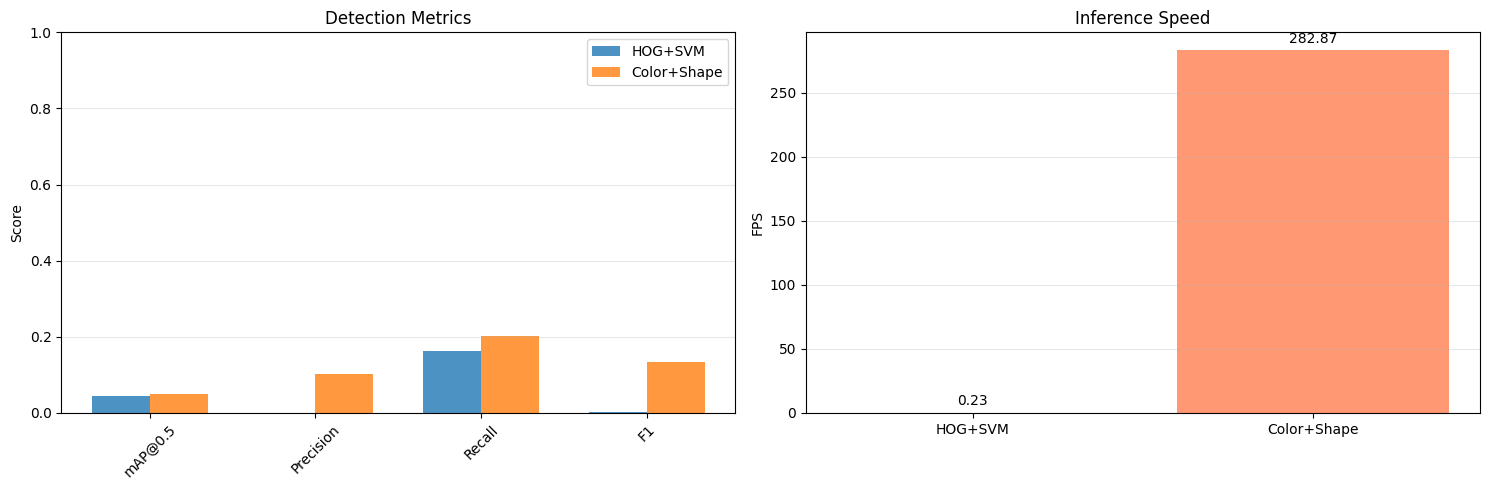


✅ Saved to: experiments/traditional_methods_comparison.png


In [11]:
# Benchmark speed
print("Benchmarking speeds...")
hog_speed = SpeedMetrics()
color_speed = SpeedMetrics()

for img_path in tqdm(val_images[:30]):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # HOG+SVM
    start = time.time()
    _ = sliding_detector.detect(img, confidence_threshold=0.5)
    hog_speed.update(time.time() - start)

    # Color+Shape
    start = time.time()
    _ = color_shape.detect(img, confidence_threshold=0.5)
    color_speed.update(time.time() - start)

hog_speed_summary = hog_speed.get_summary()
color_speed_summary = color_speed.get_summary()

# Comparison table
import pandas as pd

comparison = {
    'HOG+SVM': {
        'mAP@0.5': f"{hog_svm_metrics['mAP']:.4f}",
        'Precision': f"{hog_svm_metrics['precision']:.4f}",
        'Recall': f"{hog_svm_metrics['recall']:.4f}",
        'F1': f"{hog_svm_metrics['f1_score']:.4f}",
        'FPS': f"{hog_speed_summary['avg_fps']:.2f}"
    },
    'Color+Shape': {
        'mAP@0.5': f"{color_shape_results['mAP']:.4f}",
        'Precision': f"{color_shape_results['precision']:.4f}",
        'Recall': f"{color_shape_results['recall']:.4f}",
        'F1': f"{color_shape_results['f1_score']:.4f}",
        'FPS': f"{color_speed_summary['avg_fps']:.2f}"
    }
}

df = pd.DataFrame(comparison).T

print("\n" + "="*80)
print("TRADITIONAL METHODS COMPARISON")
print("="*80)
print(df.to_string())
print("="*80)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Metrics
metrics = ['mAP@0.5', 'Precision', 'Recall', 'F1']
hog_vals = [hog_svm_metrics['mAP'], hog_svm_metrics['precision'], hog_svm_metrics['recall'], hog_svm_metrics['f1_score']]
color_vals = [color_shape_results['mAP'], color_shape_results['precision'], color_shape_results['recall'], color_shape_results['f1_score']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, hog_vals, width, label='HOG+SVM', alpha=0.8)
axes[0].bar(x + width/2, color_vals, width, label='Color+Shape', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Detection Metrics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Speed
methods = ['HOG+SVM', 'Color+Shape']
fps = [hog_speed_summary['avg_fps'], color_speed_summary['avg_fps']]

axes[1].bar(methods, fps, alpha=0.8, color=['steelblue', 'coral'])
axes[1].set_ylabel('FPS')
axes[1].set_title('Inference Speed')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(fps):
    axes[1].text(i, v + max(fps)*0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('experiments/traditional_methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved to: experiments/traditional_methods_comparison.png")

## 6. Summary

### HOG + SVM (Sliding Window)
- ✅ Interpretable, CPU-only
- ⚠️ Slow due to sliding window, lower recall
- **Best for**: Controlled environments, interpretability needed

### Color + Shape
- ✅ Very fast, no training
- ⚠️ Lighting-sensitive, generic categories only
- **Best for**: Prototyping, pre-filtering

### Recommendations
- **Production**: Use YOLOv11 (see notebook 03)
- **CPU-only**: HOG+SVM acceptable for controlled settings
- **Embedded**: Consider quantized YOLO

**Next**: Run [03_modern_methods.ipynb](03_modern_methods.ipynb) for deep learning comparison!